# Домашнее задание 1. Autoencoders & Fréchet Inception Distance

В этом задании вы:
1. Напишете свой автоэнкодер (AE) для датасета CIFAR10.
2. Используете эмбеддинги энкодера, чтобы посчитать Fréchet Inception Distance (FID) между классами CIFAR10.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.nn import functional as F
import torch
from torch import nn
from torch.utils.data import Subset, DataLoader, Dataset
from torchvision import datasets, transforms

from sklearn.ensemble import GradientBoostingClassifier
from scipy.linalg import sqrtm
from tqdm.auto import tqdm, trange

from collections import defaultdict
import random

from PIL import Image

In [2]:
def set_seed(seed: int):
    """
    Sets the seed for reproducibility across numpy, random, torch.

    Parameters:
    seed (int): The seed value to be set.
    """
    random.seed(seed)  # Python's random module
    np.random.seed(seed)  # NumPy
    torch.manual_seed(seed)  # Torch for CPU and device-agnostic
    torch.cuda.manual_seed(seed)  # GPU: CUDA 
    torch.cuda.manual_seed_all(seed)  # Multi-GPU
    torch.backends.cudnn.deterministic = True  # Deterministic behavior for CUDA
    torch.backends.cudnn.benchmark = False  # Disable cuDNN benchmarking

SEED = 42
set_seed(SEED)

In [3]:
device: str = 'cuda' if torch.cuda.is_available() else ('mps' if torch.backends.mps.is_available() else 'cpu')
device

'mps'

Для работы с данными будем использовать `torchvision`.

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    lambda x: (x * 2) - 1
])

In [5]:
train_dataset = datasets.CIFAR10(
    '../data/cifar',
    train=True,
    transform=transform,
    download=True)
val_dataset = datasets.CIFAR10(
    '../data/cifar',
    train=False,
    transform=transform,
    download=True)
len(train_dataset), len(val_dataset)

(50000, 10000)

Нам нужно будет уметь «разнормализовать» картинки (обратно в $[0,1]$) для визуализации.

In [6]:
def denormalize_image(image):
    return (image + 1) / 2

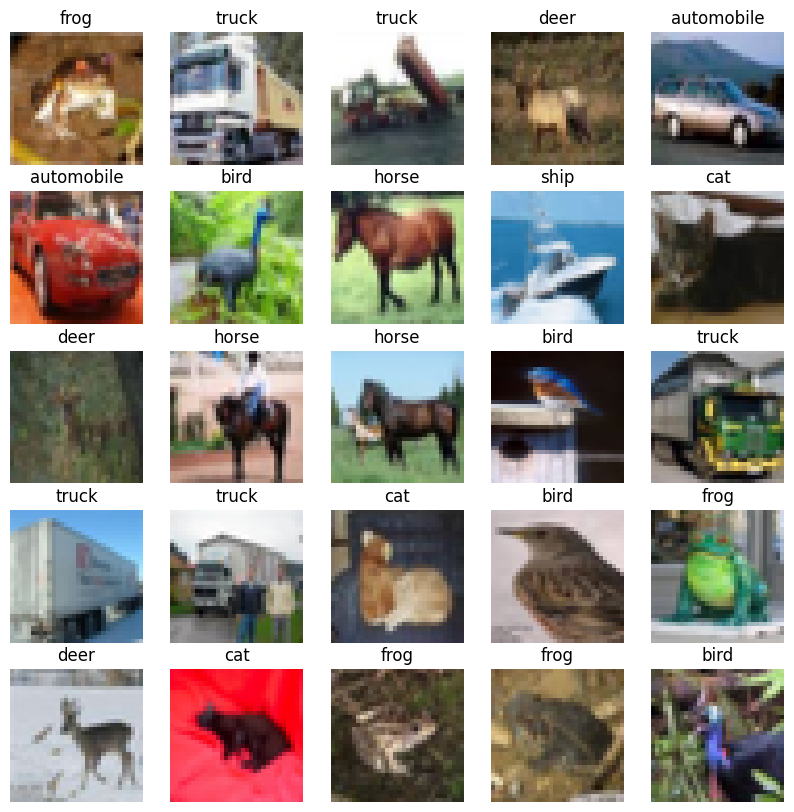

In [7]:
text_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
plt.figure(figsize=(10, 10))
for index, (image, label) in enumerate(train_dataset):
    plt.subplot(5, 5, index + 1)
    plt.imshow(denormalize_image(image.permute(1, 2, 0)))
    plt.axis('off')
    plt.title(text_labels[label])
    if index == 24: break
plt.show()

Размерность картинки в CIFAR10: 3 канала, 32×32 пикселя.

In [8]:
image.shape

torch.Size([3, 32, 32])

In [9]:
batch_size = 128

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
len(train_loader), len(val_loader)

(391, 10000)

## Задание 1. Обучить AE (3 балла)

Постройте свой AE: напишите классы `Encoder` и `Decoder`. Можно использовать любые слои, которые посчитаете нужными: `nn.Conv2d`, `nn.AvgPool2d`, `nn.MaxPool2d`, а также в декодере — `nn.Upsample`, `nn.ConvTranspose2d` и т.д.  

![](https://miro.medium.com/max/1400/1*44eDEuZBEsmG_TCAKRI3Kw@2x.png)

In [10]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.LeakyReLU(0.2)
        )

        self.layer_2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.LeakyReLU(0.2)
        )

        self.layer_3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.LeakyReLU(0.2)
        )
        
    def forward(self, x):
        x = self.layer_1(x)
        x = self.layer_2(x)
        x = self.layer_3(x)
        return x

In [11]:
encoder = Encoder()
noise = torch.rand(1, 3, 32, 32) - 1
assert encoder(noise).view(-1).shape[0] < 1*3*32*32, "Размер эмбеддинга должен быть меньше исходного!"

In [12]:
encoder(noise).shape

torch.Size([1, 32, 2, 2])

In [13]:
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=32, out_channels=32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2)
        )

        self.layer_2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2)
        )

        self.layer_3 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=16, out_channels=3, kernel_size=5),
            nn.BatchNorm2d(3),
            nn.LeakyReLU(0.2)
        )

    def forward(self, z):
        z = F.interpolate(
            z, scale_factor=2, mode='bilinear', align_corners=False
        )
        z = self.layer_1(z)

        z = F.interpolate(
            z, scale_factor=2, mode='bilinear', align_corners=False
        )
        z = self.layer_2(z)

        z = F.interpolate(
            z, scale_factor=2, mode='bilinear', align_corners=False
        )
        x = self.layer_3(z)
        return x

In [14]:
decoder = Decoder()
noise = torch.rand(1, 3, 32, 32)
emb = encoder(noise)
assert decoder(emb).shape == (1, 3, 32, 32), "Декодер должен восстанавливать тензор формы (batch_size, 3, 32, 32)"

In [15]:
def classification_score(encoder, _train_dataset, val_dataset, device, train_size=5000):
    encoder.eval()
    
    # Возьмём train_size случайных примеров для обучения GBDT
    train_dataset = Subset(_train_dataset, torch.randperm(len(_train_dataset))[:train_size])
    
    X_train = []
    y_train = []
    for image, label in tqdm(train_dataset):
        image = image.to(device)
        with torch.no_grad():
            emb = encoder(image[None, ...])
        X_train.append(emb.cpu().numpy().reshape(-1))
        y_train.append(label)
    X_train = np.stack(X_train)
    y_train = np.stack(y_train)
    
    clf = GradientBoostingClassifier(n_estimators=50, max_depth=5, verbose=1, random_state=SEED)
    clf.fit(X_train, y_train)
    
    X_val = []
    y_val = []
    for image, label in tqdm(val_dataset):
        image = image.to(device)
        with torch.no_grad():
            emb = encoder(image[None, ...])
        X_val.append(emb.cpu().numpy().reshape(-1))
        y_val.append(label)
    X_val = np.stack(X_val)
    y_val = np.stack(y_val)
    
    return clf.score(X_val, y_val)

In [16]:
pretrain_score = classification_score(Encoder().to(device), train_dataset, val_dataset, device)
pretrain_score

  0%|          | 0/5000 [00:00<?, ?it/s]

      Iter       Train Loss   Remaining Time 
         1           2.1043            3.37m
         2           1.9597            3.29m
         3           1.8466            3.23m
         4           1.7460            3.16m
         5           1.6610            3.11m
         6           1.5904            3.04m
         7           1.5238            2.98m
         8           1.4643            2.91m
         9           1.4101            2.85m
        10           1.3569            2.78m
        20           1.0053            2.08m
        30           0.7948            1.39m
        40           0.6514           41.88s
        50           0.5438            0.00s


  0%|          | 0/10000 [00:00<?, ?it/s]

0.3847

Напишите функцию `train`, которая обучает энкодер и декодер на **всём трейне**, возвращая средний MSE.

In [17]:
def train(loader, optim, encoder, decoder, device):
    encoder.train()
    decoder.train()
    criterion = nn.MSELoss()
    losses = []
    for image, _ in tqdm(loader, leave=False):
        image = image.to(device)
        optim.zero_grad()
        emd = encoder(image)
        recon_image = decoder(emd)
        loss = criterion(recon_image, image)
        loss.backward()
        optim.step()
        losses.append(loss.cpu().item())
    return sum(losses) / len(losses)

In [18]:
encoder.to(device)
decoder.to(device)

params = list(encoder.parameters()) + list(decoder.parameters())
optim = torch.optim.AdamW(params)

loss = train(train_loader, optim, encoder, decoder, device)
assert type(loss) == float, "Функция train должна возвращать float"
assert 0 < loss < 1
loss

  0%|          | 0/391 [00:00<?, ?it/s]

0.15759223579521983

Напишите функцию `eval`, которая возвращает среднее MSE на всём валидационном датасете.  
Hint: Не забудьте выключить расчёт градиентов.

In [19]:
def eval(loader, encoder, decoder, device):
    encoder.eval()
    decoder.eval()
    criterion = nn.MSELoss()
    losses = []
    with torch.no_grad():
        for image, _ in tqdm(loader, leave=False):
            image = image.to(device)
            emd = encoder(image)
            recon_image = decoder(emd)
            loss = criterion(recon_image, image)
            losses.append(loss.cpu().item())
    return sum(losses) / len(losses)

In [20]:
loss = eval(val_loader, encoder, decoder, device)
assert type(loss) == float
assert 0 < loss < 1
loss

  0%|          | 0/10000 [00:00<?, ?it/s]

0.10846377624142915

Ниже — функция `full_train`, которая возвращает обученныe энкодер и декодер. Обучите модель, а затем добавьте загрузку предобученных весов в начало функции.

In [21]:
def full_train(device, train_loader, val_loader, path_enc=None, path_dec=None):
    if path_enc and path_dec:
        encoder = Encoder()
        encoder.load_state_dict(torch.load(path_enc, map_location='cpu'))
        encoder = encoder.to(device)
        
        decoder = Decoder()
        decoder.load_state_dict(torch.load(path_dec, map_location='cpu'))
        decoder = decoder.to(device)
        
        print(f'Pre-train weights of Encoder and Decoder successfully loaded to {device}')
        return encoder, decoder
    
    encoder = Encoder().to(device)
    decoder = Decoder().to(device)
    
    params = list(encoder.parameters()) + list(decoder.parameters())
    optim = torch.optim.AdamW(params)
    train_loss = []
    val_loss = []
    n_epochs = 30
    for e in trange(n_epochs):
        e_train_loss = train(train_loader, optim, encoder, decoder, device)
        train_loss.append(e_train_loss)
        e_val_loss = eval(val_loader, encoder, decoder, device)
        val_loss.append(e_val_loss)
        print(f'Epoch: {e+1}/{n_epochs}')
        print(f'Train MSE loss: {e_train_loss:.4f}')
        print(f'Validation MSE loss: {e_val_loss:.4f}')
    plt.plot(train_loss, label='train')
    plt.plot(val_loss, label='val')
    plt.legend()
    plt.title('MSE Loss')
    plt.grid()
    plt.show()
    return encoder, decoder

In [22]:
# we already have trained encoder and decoder
encoder, decoder = full_train(device, train_loader, val_loader,
                             path_enc='encoder_weights.pth', path_dec='decoder_weights.pth')

# if want train - comment code above and uncommetn code below
# encoder, decoder = full_train(device, train_loader, val_loader)

Pre-train weights of Encoder and Decoder successfully loaded to mps


In [23]:
score = classification_score(encoder, train_dataset, val_dataset, device, train_size=5000)
assert score > pretrain_score * 1.05, "Слишком низкий скор. Убедитесь, что ваш AE обучается."
score

  0%|          | 0/5000 [00:00<?, ?it/s]

      Iter       Train Loss   Remaining Time 
         1           2.1054            3.36m
         2           1.9703            3.29m
         3           1.8509            3.23m
         4           1.7455            3.15m
         5           1.6576            3.08m
         6           1.5823            3.01m
         7           1.5182            2.95m
         8           1.4573            2.88m
         9           1.3980            2.81m
        10           1.3438            2.76m
        20           0.9693            2.10m
        30           0.7444            1.40m
        40           0.6027           42.21s
        50           0.4979            0.00s


  0%|          | 0/10000 [00:00<?, ?it/s]

0.4086

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.07265055..1.078177].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.107791364..1.0422174].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.20599625..1.0081966].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.065265715..0.77557313].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.026942909..0.9372143].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.09114194..1.1480556].


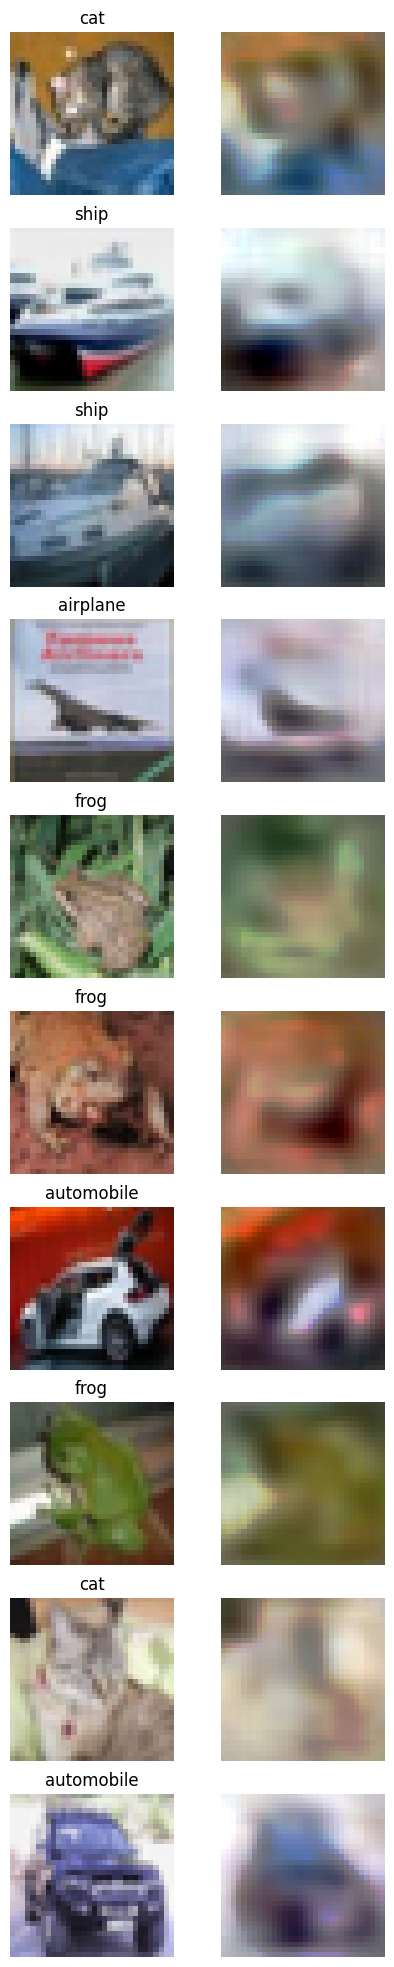

In [24]:
encoder.eval()
decoder.eval()
plt.figure(figsize=(5, 25))
for index, (image, label) in enumerate(val_loader):
    plt.subplot(10, 2, index*2 + 1)
    plt.imshow(denormalize_image(image)[0].permute(1, 2, 0))
    plt.axis('off')
    plt.title(text_labels[label])
    plt.subplot(10, 2, index*2 + 2)
    image = image.to(device)
    with torch.no_grad():
        emb = encoder(image)
        rec = decoder(emb).cpu()
    plt.imshow(denormalize_image(rec)[0].permute(1, 2, 0))
    plt.axis('off')
    
    if index == 9:
        break

## Задание 2. FID дистанция между классами CIFAR10 (3 балла)

Теперь, используя bottleneck-представления обученного энкодера, посчитаем **Fréchet Inception Distance (FID)** между разными классами CIFAR10 на **валидационной** выборке.

Напомним формулу FID:
$$
\mathrm{FID} = \|\mu_r - \mu_g\|^2 + \operatorname{Tr}(\Sigma_r + \Sigma_g - 2(\Sigma_r \Sigma_g)^{1/2}).
$$

Реализуйте функцию `get_representations`, которая для заданного `DataLoader` и энкодера вернёт `defaultdict`, где:
- ключ: номер класса
- значение: список тензоров, соответствующих эмбеддингам картинок этого класса.

In [25]:
def get_representations(dataloader, encoder, device):
    representations = defaultdict(list)
    encoder.eval()
    with torch.no_grad():
        for image, label in tqdm(dataloader):
            representations[label.item()].append(encoder(image.to(device)))
    return representations

In [26]:
representations = get_representations(val_loader, encoder, device)
assert len(representations) == 10, "Должно быть 10 ключей по количеству классов."
assert len(representations[0]) == 1000, "Количество эмбеддингов на класс не совпадает с ожидаемым."
assert type(representations[0][0]) == torch.Tensor

  0%|          | 0/10000 [00:00<?, ?it/s]

In [27]:
def calculate_fid(repr1, repr2, eps=1e-6):
    mean_repr_1 = repr1.mean(axis=0)
    mean_repr_2 = repr2.mean(axis=0)

    sigma_repr_1 = np.cov(repr1, rowvar=False)
    sigma_repr_2 = np.cov(repr2, rowvar=False)

    first_term = ((mean_repr_1 - mean_repr_2)**2).sum()
    mat_sqrt, _ = sqrtm(sigma_repr_1.dot(sigma_repr_2), disp=False)
    if np.iscomplexobj(mat_sqrt):
        mat_sqrt = mat_sqrt.real
    second_term = sigma_repr_1 + sigma_repr_2 - 2 * mat_sqrt

    fid = first_term + np.linalg.trace(second_term)
    return fid

In [28]:
# Посчитаем FID для каждой пары классов и сохраним в heatmap (10×10)
heatmap = np.zeros((10, 10))
for label_from in trange(10):
    for label_to in range(10):
        fid = calculate_fid(
            torch.stack(representations[label_from], dim=0).reshape(len(representations[0]), -1).cpu().detach().numpy(),
            torch.stack(representations[label_to], dim=0).reshape(len(representations[0]), -1).cpu().detach().numpy()
        )
        heatmap[label_from, label_to] = fid

# Проверки на корректность вычислений:
assert heatmap.shape == (10, 10), "Массив должен быть 10×10."
assert np.all(heatmap + 1e-5 > 0), "FID не может быть отрицательной."
airplane_ship = heatmap[0, 8]  # fid(airplane, ship)
airplane_frog = heatmap[0, 6]  # fid(airplane, frog)
truck_automobile = heatmap[9, 1]  # fid(truck, automobile)
truck_dog = heatmap[9, 5]  # fid(truck, dog)
assert airplane_ship < airplane_frog, "Ожидаем, что класс airplane ближе к ship, чем к frog"
assert truck_automobile < truck_dog, "Ожидаем, что класс truck ближе к automobile, чем к dog"

  0%|          | 0/10 [00:00<?, ?it/s]

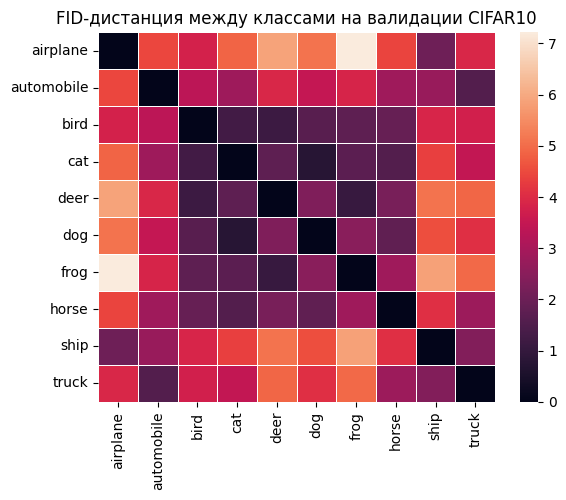

In [29]:
sns.heatmap(
    heatmap, 
    linewidth=0.5, 
    xticklabels=text_labels, 
    yticklabels=text_labels
)
plt.title('FID-дистанция между классами на валидации CIFAR10')
plt.show()

## Задание 3 (3 балла)

Возьмите **любой** датасет из интернета, в котором есть **два разных класса** (например, «кошки и собаки», или какие-то другие). Посчитайте между ними FID, используя **тот же энкодер** (обученный на CIFAR10).

$\textbf{Remark}:$ 

Загрузка датасета требует 600-700 мб памяти, но это можно делать сразу из ```kagglehub```, сразу в ноутбуке, поэтом надо установить дополнительную библиотеку

In [30]:
!pip3.11 install kagglehub


[notice] A new release of pip is available: 25.1.1 -> 26.0.1
[notice] To update, run: pip3.11 install --upgrade pip


In [31]:
import kagglehub
import os

# Download latest version
path = kagglehub.dataset_download("alessiocorrado99/animals10")

print("Path to dataset files:", path)

Path to dataset files: /Users/kirill/.cache/kagglehub/datasets/alessiocorrado99/animals10/versions/2


In [32]:
translate = {"cane": "dog", "cavallo": "horse", "elefante": "elephant", "farfalla": "butterfly", 
             "gallina": "chicken", "gatto": "cat", "mucca": "cow", "pecora": "sheep", 
             "scoiattolo": "squirrel", "cavallo": "horse",  
             "ragno": "spider"}

In [33]:
data_dir = os.path.join(path, "raw-img")
print(f'Original classes: {os.listdir(os.path.join(data_dir))}\n')
for name in os.listdir(os.path.join(data_dir)):
    try:
        os.rename(os.path.join(data_dir, name), os.path.join(data_dir, translate[name]))
    except:
        print(f'{name} have been already translated or it is not an animal class')
print(f'\nTranslated classes: {os.listdir(os.path.join(data_dir))}')

Original classes: ['cat', 'butterfly', '.DS_Store', 'dog', 'sheep', 'spider', 'chicken', 'horse', 'squirrel', 'cow', 'elephant']

cat have been already translated or it is not an animal class
butterfly have been already translated or it is not an animal class
.DS_Store have been already translated or it is not an animal class
dog have been already translated or it is not an animal class
sheep have been already translated or it is not an animal class
spider have been already translated or it is not an animal class
chicken have been already translated or it is not an animal class
horse have been already translated or it is not an animal class
squirrel have been already translated or it is not an animal class
cow have been already translated or it is not an animal class
elephant have been already translated or it is not an animal class

Translated classes: ['cat', 'butterfly', '.DS_Store', 'dog', 'sheep', 'spider', 'chicken', 'horse', 'squirrel', 'cow', 'elephant']


In [34]:
class AnimalDataset(Dataset):
    def __init__(self, dir_path, transform=None):
        self.dir_path = dir_path
        self.transform = transform
        self.classes = [
            'cat', 'butterfly', 'dog', 'sheep', 
            'spider', 'chicken', 'horse', 'squirrel', 
            'cow', 'elephant'
        ]
        
        self.image_paths = []
        self.labels = []
        
        for class_idx, class_name in enumerate(self.classes):
            class_dir = os.path.join(dir_path, class_name)
            if os.path.exists(class_dir):
                for img_name in os.listdir(class_dir):
                    img_path = os.path.join(class_dir, img_name)
                    self.image_paths.append(img_path)
                    self.labels.append(class_idx)
                    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.item()
            
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)
            
        return image, label
    
    def get_class_name(self, class_idx):
        return self.classes[class_idx]

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/_tensor.py:1025: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.3815467..1.1288539].


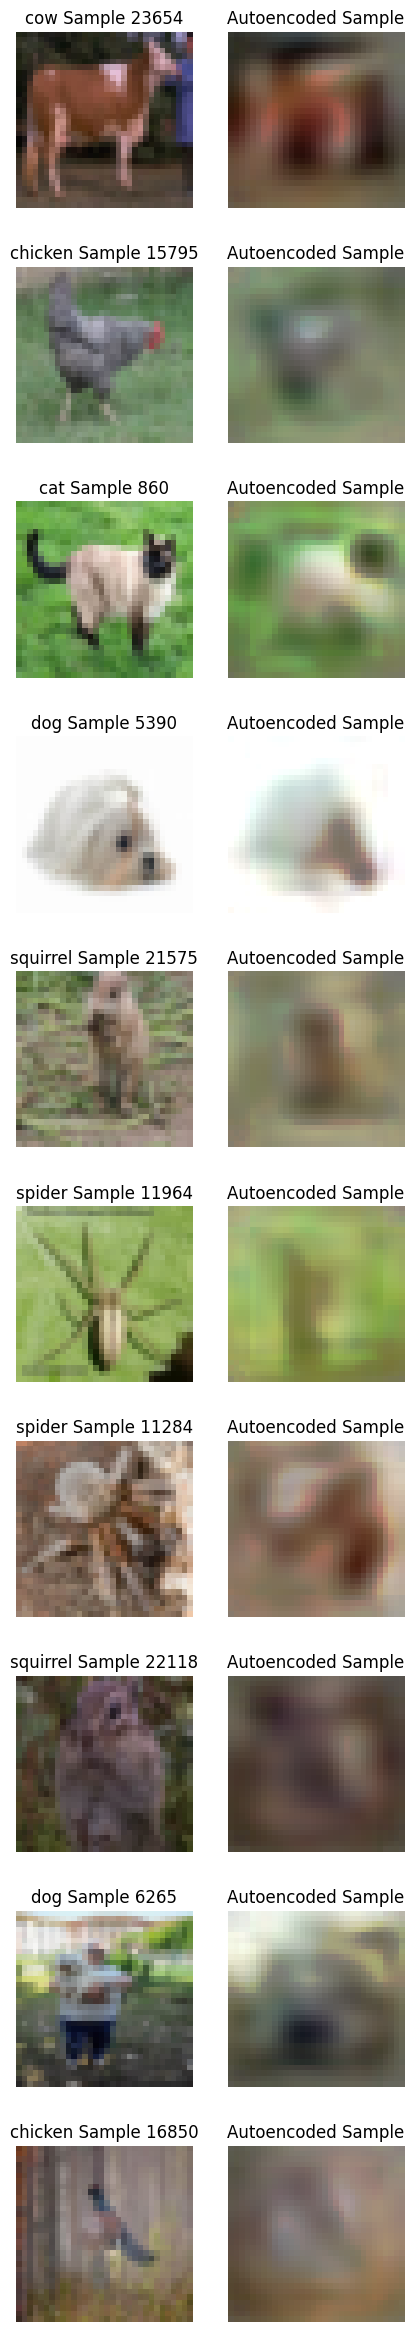

In [35]:
transform_animal = transforms.Compose([
    transforms.Resize((32, 32)), # Example size
    transforms.ToTensor(),
    lambda x: (x * 2) - 1
])

animal_dataset = AnimalDataset(dir_path=data_dir, transform=transform_animal)

plt.figure(figsize=(5, 30))
random_images = np.random.randint(0, len(animal_dataset), 10)
for pos, index in enumerate(random_images):
    sample, label = animal_dataset[index]
    plt.subplot(10, 2, pos*2 + 1)
    plt.imshow(denormalize_image(sample).permute(1, 2, 0))
    plt.axis('off')
    plt.title(f'{animal_dataset.get_class_name(label)} Sample {index}')
    
    plt.subplot(10, 2, pos*2 + 2)
    sample = sample.resize(1, 3, 32, 32).to(device)
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        emb = encoder(sample)
        rec = decoder(emb).cpu()
    plt.imshow(denormalize_image(rec)[0].permute(1, 2, 0))
    plt.axis('off')
    plt.title(f'Autoencoded Sample')

$\textbf{Remark}:$ 

Если прогнать много разных сэмплов из датасета, то видно, что наш AE работает очень неплохо для тех изобрадений, где четко видны животнеы ( в частности коты, собаки, овцы, кони).

Для изображений, где нет четко видных животных выход из AE выглядит хуже. Но даже для тех классов, которые отсутствовали в обучающей выборки результат достаточно неплохой

Немного изменим функцию для подготовки к подсчету FID

Тут есть ```try except``` чтобы быстро отрабатывать ошибки связанные с размерностью картинок (почему то в датасете есть 4-ех канальные изображения)

In [36]:
label2index = {animal: i for i, animal in enumerate(animal_dataset.classes)}
def get_representations_animal(dataset, encoder, device):
    representations = defaultdict(list)
    encoder.eval()
    with torch.no_grad():
        for image, label in tqdm(dataset):
            try:
                representations[label2index[dataset.get_class_name(label)]].append(encoder(image.unsqueeze(0).to(device)))
            except:
                continue
    return representations

In [37]:
representations_animals = get_representations_animal(animal_dataset, encoder, device)
for key in representations_animals.keys():
    print(len(representations_animals[key]), key)

  0%|          | 0/26179 [00:00<?, ?it/s]

1667 0
2073 1
4863 2
1820 3
4820 4
3098 5
2623 6
1862 7
1866 8
1436 9


In [38]:
# Посчитаем FID для каждой пары классов и сохраним в heatmap (10×10)
heatmap_animal = np.zeros((10, 10))
for label_from in trange(10):
    for label_to in range(10):
        fid = calculate_fid(
            torch.stack(representations_animals[label_from], dim=0).reshape(len(representations_animals[label_from]), -1).cpu().detach().numpy(),
            torch.stack(representations_animals[label_to], dim=0).reshape(len(representations_animals[label_to]), -1).cpu().detach().numpy()
        )
        heatmap_animal[label_from, label_to] = fid

  0%|          | 0/10 [00:00<?, ?it/s]

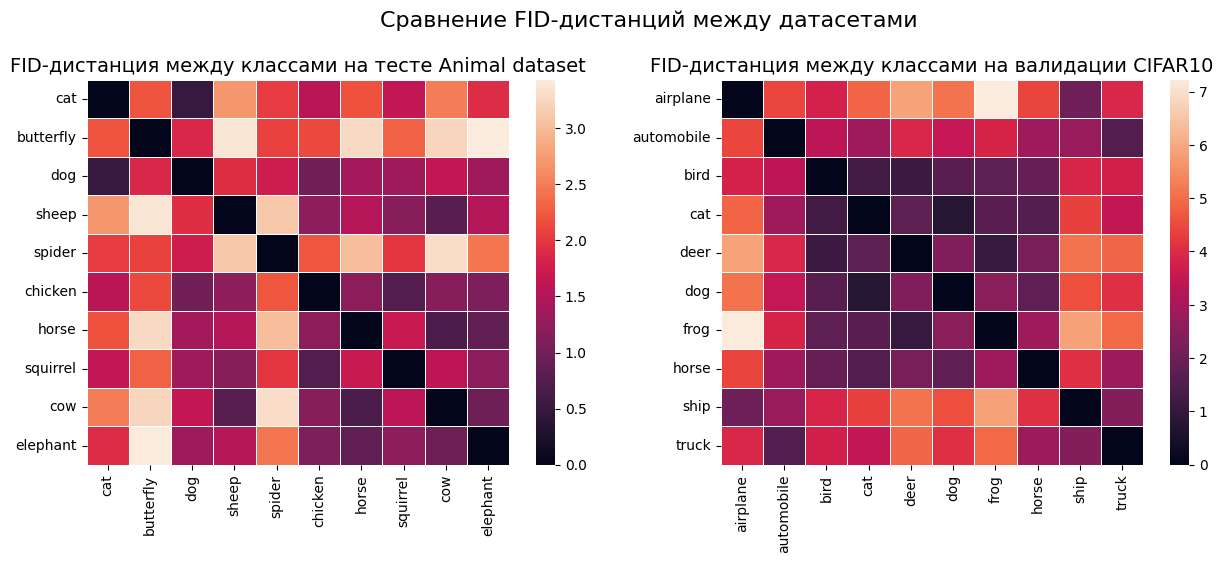

In [39]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

sns.heatmap(
    heatmap_animal, 
    linewidth=0.5, 
    xticklabels=label2index.keys(), 
    yticklabels=label2index.keys(),
    ax=ax1
)
ax1.set_title('FID-дистанция между классами на тесте Animal dataset', fontsize=14)

sns.heatmap(
    heatmap, 
    linewidth=0.5, 
    xticklabels=text_labels, 
    yticklabels=text_labels,
    ax=ax2
)
ax2.set_title('FID-дистанция между классами на валидации CIFAR10', fontsize=14)

fig.suptitle('Сравнение FID-дистанций между датасетами', fontsize=16, y=1.02)

plt.show()

$\textbf{Remark}:$

Видим, что некоторые расстояния немного выбиваются из логики: например корова очень близка к белке, но в целом видно что наш AE работает достаточно хорошо.

Например, расстояние между собакой и бабочко больше чем между собакой и кошкой, или между лошадью и коровой - меньше чем между лошадью и пауком или лошадью и бабочкой.

Мы видим, что этот дадасет немного шумный, так как на изображениях могут присутсовать например люди или какие-то большие предметы, поэтому расстояние между кошкой и собакой здесь немного больше чем на CIFAR10.

## Задание 4 (1 балл)

Поздравляем, вы проделали большую работу! В этом разделе:
1. Опишите идеи, которые вы хотели бы попробовать, если бы у вас было больше времени или статьи, в которых решают подобные задачи.  
2. Приложите какой-нибудь свежий (последних пары лет) мем про генеративные модели. Если мем будет не смешным, увы, придётся снять баллы.

$\textbf{Answer:}$

1. Интересно было бы попробовать реализовать более тяжелую модель, либо поискать более обширные датасеты, что обучить AE, который с большой точность мог воспроизодить изображения огромного количества различных клаасов, сделать некоторую обобщающую модель, которая таким образом могла бы делать четкие эмбединги для разных изображений. Так как например, мы имеем такой результат, что обученная на CIFAR10 AE не очень хорошо распространим на другие клаасы - есть сильные неточности, даже на валибации CIFAR10. В этой связи нашел например такие работы - https://arxiv.org/pdf/2407.07544, интересно было бы поресерчить также про Sparse Autoencoders для ллмов, например что-то такое, https://arxiv.org/pdf/2309.08600


2. Недавно увидел такой мем, по-момему достаточно забавно:

![](https://pleated-jeans.com/wp-content/uploads/2024/05/funny-ai-memes-9.webp)